### 观察数据特征

In [1]:
import numpy as np
import scipy.io as sio

In [2]:
cluster_data = sio.loadmat('cluster_data.mat')
cluster_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Jun 20 10:28:13 2013',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[ 0.09168852,  0.33141867],
        [-0.36649375,  0.20789221],
        [ 0.21681759, -0.02151629],
        ...,
        [-0.13319131, -0.75694518],
        [ 0.2338157 ,  0.48236357],
        [ 0.00705063,  0.66820813]])}

In [3]:
X = cluster_data['X']
X.shape

(4078, 2)

In [4]:
import matplotlib.pyplot as plt

def plot(X, idx, title):
    '''
    Show clustering results

    Input:  X: data point features, n-by-p maxtirx.
            idx: data point cluster labels, n-by-1 vector.
    '''
    plt.figure(figsize=(6, 6))
    plt.plot(X[idx==0, 0],X[idx==0,1],'r.',markersize=5, label='Cluster 1')
    plt.plot(X[idx==1, 0],X[idx==1,1],'b.', markersize=5, label='Cluster 2')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

[ 0.09168852 -0.36649375  0.21681759 ... -0.13319131  0.2338157
  0.00705063]
[ 0.33141867  0.20789221 -0.02151629 ... -0.75694518  0.48236357
  0.66820813]


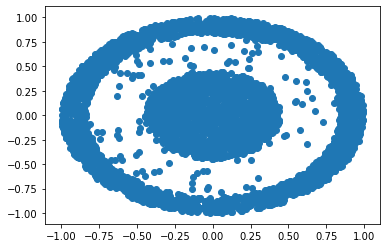

In [5]:
x = X[:, 0]
y = X[:, 1]
print(x)
print(y)
plt.scatter(x, y)
plt.show()

### K-means函数实现

In [6]:
import numpy as np
from scipy.spatial.distance import cdist
import random

def kmeans(X, k):
    N, P = X.shape
    idx = np.zeros(N)
    
    # k-means迭代次数
    EPOCH = 50
    
    # 随机选取两个中心点
    centers = random.sample(list(X), 2)
    # 初始化下标数组
    idx = np.empty(len(X))

    for epoch in range(EPOCH):
        for i in range(len(X)):     
            # 计算每个样本点到两个中心点的距离
            dis1 = abs(sum((centers[0] - X[i])**2))
            dis2 = abs(sum((centers[1] - X[i])**2))
            # 离第一个样本点近，则idx=0，离第二个样本点近，则idx=1
            if dis1 < dis2:
                idx[i] = 0
            else:
                idx[i] = 1

        # 计算出cluster1和cluster2的中心点c1,c2
        sum1, sum2 = np.zeros(2), np.zeros(2)
        for j in range(len(idx)):
            if idx[j] == 0:
                sum1 += X[j]
            elif idx[j] == 1:
                sum2 += X[j]
        centers[0] = sum1 / sum(1-idx)
        centers[1] = sum2 / sum(idx)
        
    return idx

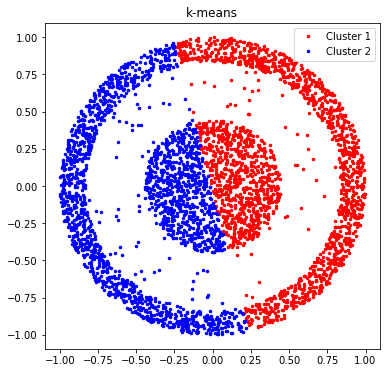

In [7]:
idx = kmeans(X, 2)
plot(X, idx, 'k-means')

### 谱聚类(spectral clustering)函数实现

Similarity Matrix这里利用knn构建，可以尝试RBF function以获取更好的效果

In [8]:
def knn_graph(X, k, threshold):
    '''
    Construct W using KNN graph

    Input:  X:data point features, N-by-P maxtirx.
            k: number of nearest neighbour.
            threshold: distance threshold.

    Output:  W - adjacency matrix, N-by-N matrix.
    '''
    N = X.shape[0]
    W = np.zeros((N, N))
    aj = cdist(X, X, 'euclidean')
    for i in range(N):
        index = np.argsort(aj[i])[:(k+1)]  # aj[i,i] = 0
        W[i, index] = 1
    W[aj >= threshold] = 0
    return W


In [9]:
def spectral(W, k):
    '''
    Spectral clustering algorithm

    Input:  W: Adjacency matrix, N-by-N matrix
            k: number of clusters

    Output:  idx: data point cluster labels, N-by-1 vector
    '''
    N = W.shape[0]
    idx = np.zeros(N)

    # W = Similarity Matrix
    # D = Degree Matrix
    D = np.sum(W, axis=1)
    # L = Laplacian Matrix = D - W
    L = np.diag(D) - W
    # D^(-1/2)
    _D = np.diag(1.0 / D**0.5) 
    # normalize L = D^(-1/2) @ L @ D^(-1/2) 
    norm_L = _D @ L @ _D

    # lamda = eigenvalue, vector = eigenvector
    lamda, vector = np.linalg.eig(norm_L)
    # find the min eigenvalue
    lamda_sort = np.argsort(lamda)
    # eigenvector is the result of dimension reduction with high density connective relation
    # choose 2-dimension eigenvector correspond to 2 smallest eigenvalue for visualize
    Laplacian_Eigenmaps = vector[:, lamda_sort[:2]]

    # complex -> float
    Laplacian_Eigenmaps = Laplacian_Eigenmaps.astype(float)
    
    # k-means for spectral clustering, get idx for sample points with new features
    # 新的特征更关注在high density region下的连通性，因此做k-means聚类时，连通的样本点距离更接近
    idx = kmeans(Laplacian_Eigenmaps, k)
    
    return idx

/home/gehao/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


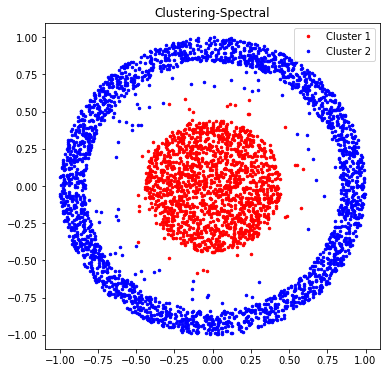

In [10]:
# 提示：这段代码需要运行较长时间...
W = knn_graph(X, 15, 1.45)
idx = spectral(W, 2)
plot(X, idx, 'Clustering-Spectral')

### 以下代码做调试用

In [11]:
W = knn_graph(X, 15, 1.45)
W

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [12]:
D = np.sum(W, axis=1)
L = np.diag(D) - W
_D = np.diag(1.0 / D**0.5) # D^(-1/2)
norm_L = _D @ L @ _D
norm_L

array([[0.9375, 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.9375, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.9375, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.9375, 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.9375, 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.9375]])

In [13]:
# 特征值和特征向量
lamda, vector = np.linalg.eig(norm_L)
lamda_sort = np.argsort(lamda)
Laplacian_Eigenmaps = vector[:, lamda_sort[:2]]
Laplacian_Eigenmaps

array([[-0.01565945+0.j, -0.00417811+0.j],
       [-0.01565945+0.j, -0.00417938+0.j],
       [-0.01565945+0.j, -0.00418207+0.j],
       ...,
       [-0.01565945+0.j,  0.01949231+0.j],
       [-0.01565945+0.j, -0.00316174+0.j],
       [-0.01565945+0.j,  0.01665927+0.j]])

/home/gehao/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


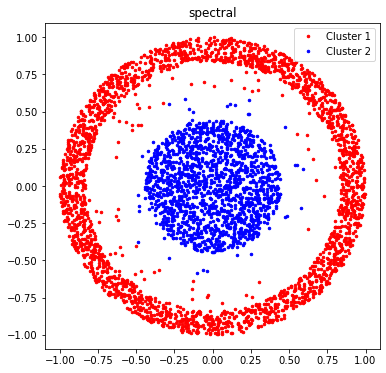

In [16]:
idx = kmeans(Laplacian_Eigenmaps.astype(float), 2)
plot(X, idx, 'spectral')